In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
pd.set_option("display.max_columns",10000)
pd.set_option("display.max_rows",10000)

In [3]:
df = pd.read_csv("../data/ONE_card_rating.csv")

In [4]:
df.head()

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Sword of Forge and Frontier,NaN,M,2345,1.05,2252,1.05,13533,56.0%,2367,58.9%,3009,59.3%,5376,59.1%,8098,53.8%,5.3pp
1,"Vraska, Betrayal's Sting",B,M,2425,1.10,2087,1.09,10948,53.8%,1817,55.2%,2549,59.5%,4366,57.7%,6521,50.9%,6.8pp
2,The Eternal Wanderer,W,R,5028,1.16,4427,1.15,24795,58.2%,4181,62.9%,5753,66.1%,9934,64.8%,14789,53.7%,11.1pp
3,"Nissa, Ascended Animist",G,M,2558,1.16,2178,1.15,11594,58.0%,1913,63.9%,2689,68.6%,4602,66.7%,6957,52.1%,14.5pp
4,"Elesh Norn, Mother of Machines",W,M,2526,1.16,2172,1.15,11930,57.5%,1972,62.1%,2671,62.6%,4643,62.4%,7248,54.3%,8.1pp


In [5]:
#TODO groupby pick order and check average winrate and IWD at each pick, check deviation from norm
#TODO check correaltion betwen pick order and winrate
#TODO plot pick order and winrate per card

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      265 non-null    object 
 1   Color     225 non-null    object 
 2   Rarity    265 non-null    object 
 3   # Seen    265 non-null    int64  
 4   ALSA      265 non-null    float64
 5   # Picked  265 non-null    int64  
 6   ATA       265 non-null    float64
 7   # GP      265 non-null    int64  
 8   GP WR     259 non-null    object 
 9   # OH      265 non-null    int64  
 10  OH WR     259 non-null    object 
 11  # GD      265 non-null    int64  
 12  GD WR     259 non-null    object 
 13  # GIH     265 non-null    int64  
 14  GIH WR    261 non-null    object 
 15  # GNS     265 non-null    int64  
 16  GNS WR    263 non-null    object 
 17  IWD       261 non-null    object 
dtypes: float64(2), int64(7), object(9)
memory usage: 37.4+ KB


In [7]:
#we have missing data in column GD WR which I want to use, let's check it out
df[df["GD WR"].isna() == True]

,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
134,Ichormoon Gauntlet,U,M,9725,4.27,1377,6.05,397,NaN,66,NaN,92,NaN,158,NaN,237,50.6%,NaN
171,Mindsplice Apparatus,U,R,23300,5.05,2846,7.76,530,NaN,76,NaN,144,NaN,220,35.0%,310,42.9%,-7.9pp
186,Monument to Perfection,NaN,R,26780,5.54,3302,8.51,497,NaN,82,NaN,115,NaN,197,NaN,296,41.6%,NaN
189,Encroaching Mycosynth,U,R,26589,5.65,3322,8.64,490,NaN,89,NaN,116,NaN,205,38.5%,285,42.8%,-4.3pp
204,Mirran Safehouse,NaN,R,29435,6.17,3852,9.20,27,NaN,5,NaN,4,NaN,9,NaN,18,NaN,NaN
263,Minor Misstep,U,U,92180,8.55,10396,12.26,82,NaN,10,NaN,18,NaN,28,NaN,54,NaN,NaN


The cards with no winrate have very few games were they are actually played which is probably the reason why the winrate is null. We can drop them safely, although there is a risk that we are dropping card that are undervalued we lack data to evaluate those cards correctly.

In [8]:
#reducing the dataframe to relevant columns
df = df[["Name", "Color", "Rarity", "ATA", "GD WR", "IWD"]]

In [9]:
df = df.dropna()

In [10]:
#converting the win rate and increase win rate to float
df["GD WR"] = df["GD WR"].apply(lambda x: float(x[:-1]))
df["IWD"] = df["IWD"].apply(lambda x: float(x[:-2]))

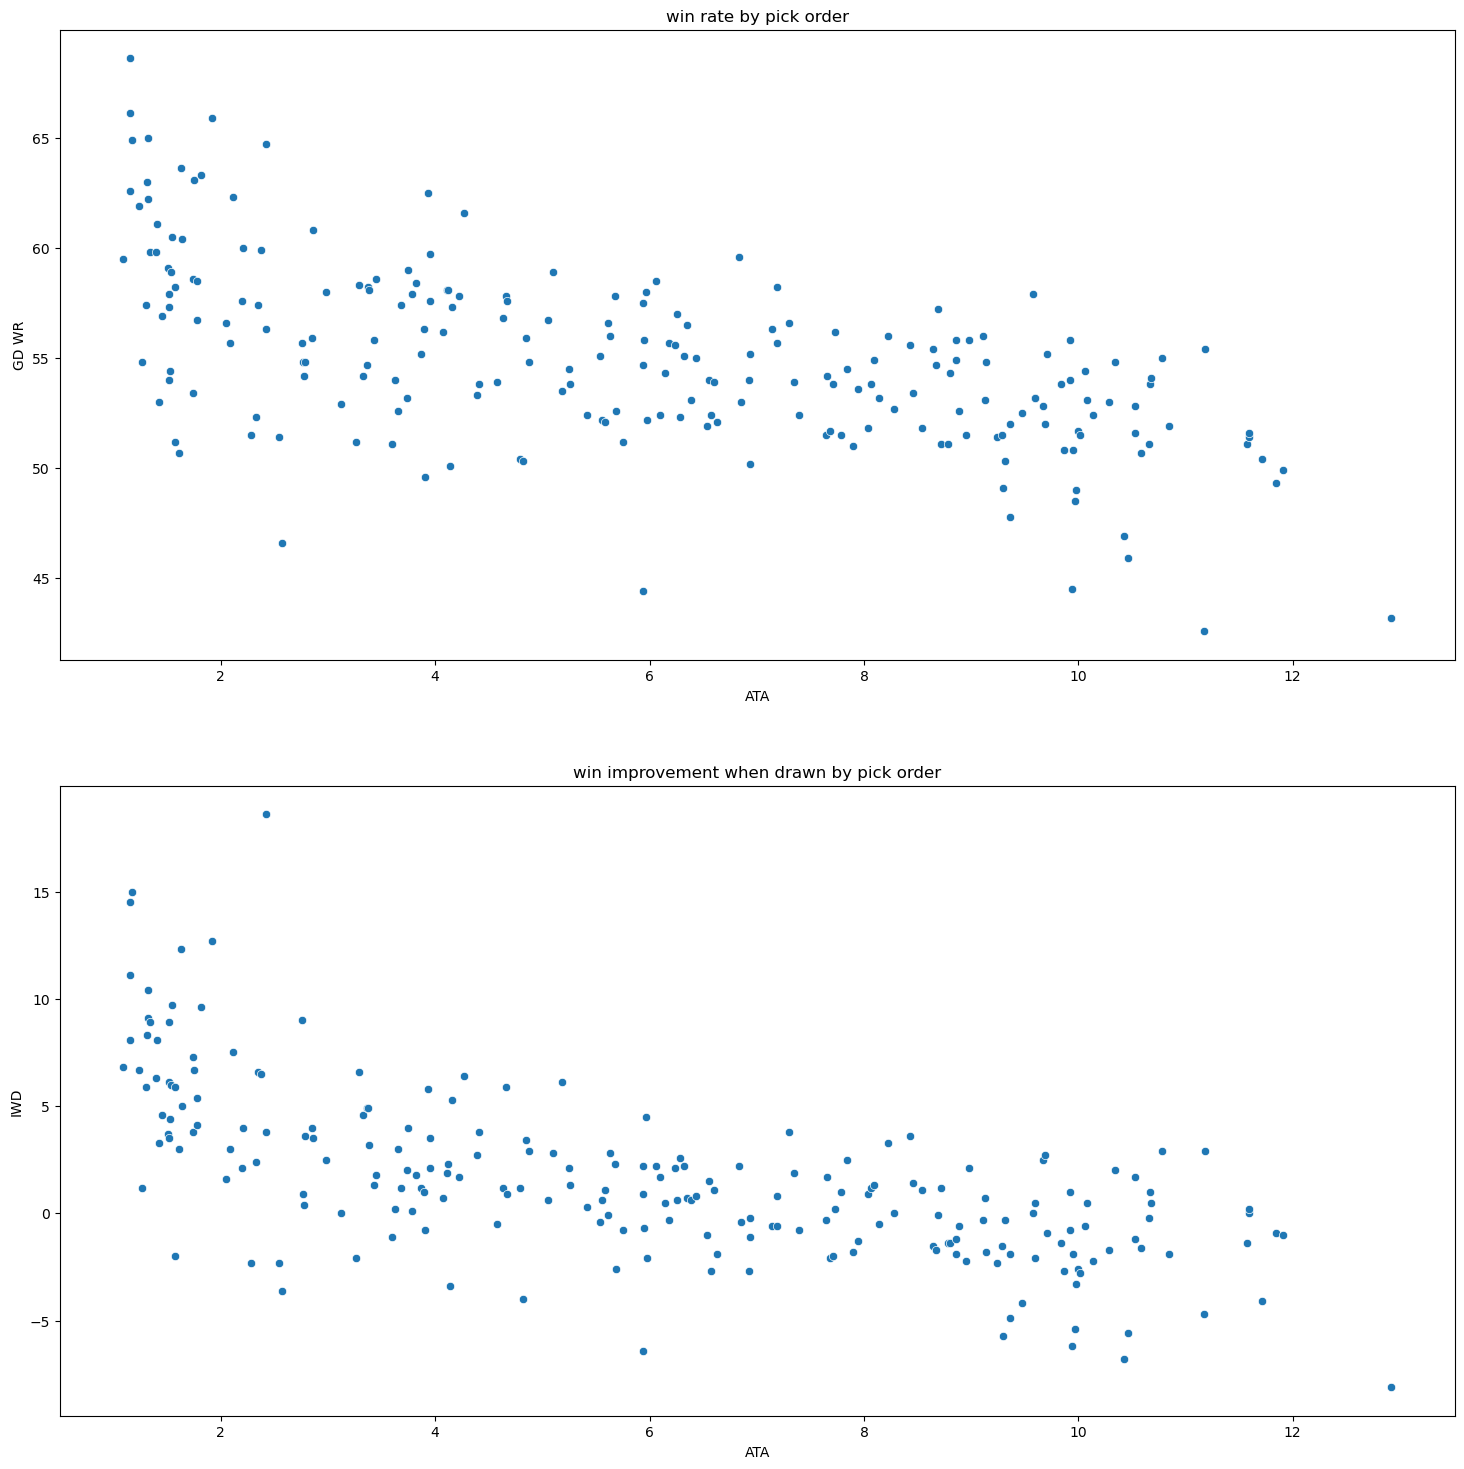

In [23]:
#plot of win rate over pick order
fig, ax = plt.subplots(nrows=2, figsize=(18,18))
sns.scatterplot(data=df, x="ATA", y="GD WR", ax=ax[0])
ax[0].set(title="win rate by pick order")
sns.scatterplot(data=df, x="ATA", y="IWD", ax=ax[1])
ax[1].set(title="win improvement when drawn by pick order")
plt.show()


A simple plot shows that we have visual outliers. Let's outline them using the interquartile range for each pick order.

In [12]:
df["rounded_pick_order"] = df["ATA"].apply(lambda x: round(x, 0))

In [13]:
q1 = df.groupby("rounded_pick_order")[["GD WR", "IWD"]].quantile(0.25)
q3 = df.groupby("rounded_pick_order")[["GD WR", "IWD"]].quantile(0.75)

In [14]:
quartile = pd.merge(q1, q3, left_on="rounded_pick_order", right_on="rounded_pick_order", suffixes=('_q1', '_q3'))

In [15]:
df = pd.merge(df, quartile, left_on='rounded_pick_order', right_on='rounded_pick_order')

In [16]:
df.columns

Index(['Name', 'Color', 'Rarity', 'ATA', 'GD WR', 'IWD', 'rounded_pick_order',
       'GD WR_q1', 'IWD_q1', 'GD WR_q3', 'IWD_q3'],
      dtype='object')

In [17]:
df["IWD_iqr"] = df["IWD_q3"] - df["IWD_q1"]
df["GD WR_iqr"] = df["GD WR_q3"] - df["GD WR_q1"]

In [46]:
def is_outlier(df, col, q1_col, q3_col, iqr_col):
    
    if df[col] > df[q3_col] + df[iqr_col] * 1.5 or df[col] < df[q1_col] - df[iqr_col] * 1.5:
        return True
    else:
        return False
    
df["IWD_outlier"] = df.apply(is_outlier, args=("IWD", "IWD_q1","IWD_q3", "IWD_iqr",), axis=1)
df["GD_WR_outlier"] = df.apply(is_outlier, args=("GD WR", "GD WR_q1", "GD WR_q3", "GD WR_iqr"), axis=1)

In [19]:
df[df["IWD_outlier"] == True]

,Name,Color,Rarity,ATA,GD WR,IWD,rounded_pick_order,GD WR_q1,IWD_q1,GD WR_q3,IWD_q3,IWD_iqr,GD WR_iqr,IWD_outlier,GD_WR_outlier
2,"Nissa, Ascended Animist",G,M,1.15,68.6,14.5,1.0,58.975,6.200,63.475,9.425,3.225,4.50,True,False
4,"Sheoldred, the Apocalypse",B,M,1.17,64.9,15.0,1.0,58.975,6.200,63.475,9.425,3.225,4.50,True,False
6,"Mondrak, Glory Dominus",W,M,1.27,54.8,1.2,1.0,58.975,6.200,63.475,9.425,3.225,4.50,True,False
23,"Drivnod, Carnage Dominus",B,M,1.57,51.2,-2.0,2.0,55.850,3.550,60.300,7.150,3.600,4.45,True,False
34,"Migloz, Maze Crusher",RG,R,1.92,65.9,12.7,2.0,55.850,3.550,60.300,7.150,3.600,4.45,True,False
40,"Nahiri, the Unforgiving",WR,M,2.28,51.5,-2.3,2.0,55.850,3.550,60.300,7.150,3.600,4.45,True,False
44,"Atraxa, Grand Unifier",WUBG,M,2.42,64.7,18.6,2.0,55.850,3.550,60.300,7.150,3.600,4.45,True,False
81,Conduit of Worlds,G,R,4.14,50.1,-3.4,4.0,53.550,0.850,58.100,3.250,2.400,4.55,True,False
92,Norn's Wellspring,W,R,4.82,50.3,-4.0,5.0,53.575,0.675,56.775,2.875,2.200,3.20,True,False
109,"Geth, Thane of Contracts",B,R,5.94,44.4,-6.4,6.0,52.400,-0.300,56.500,2.200,2.500,4.10,True,True


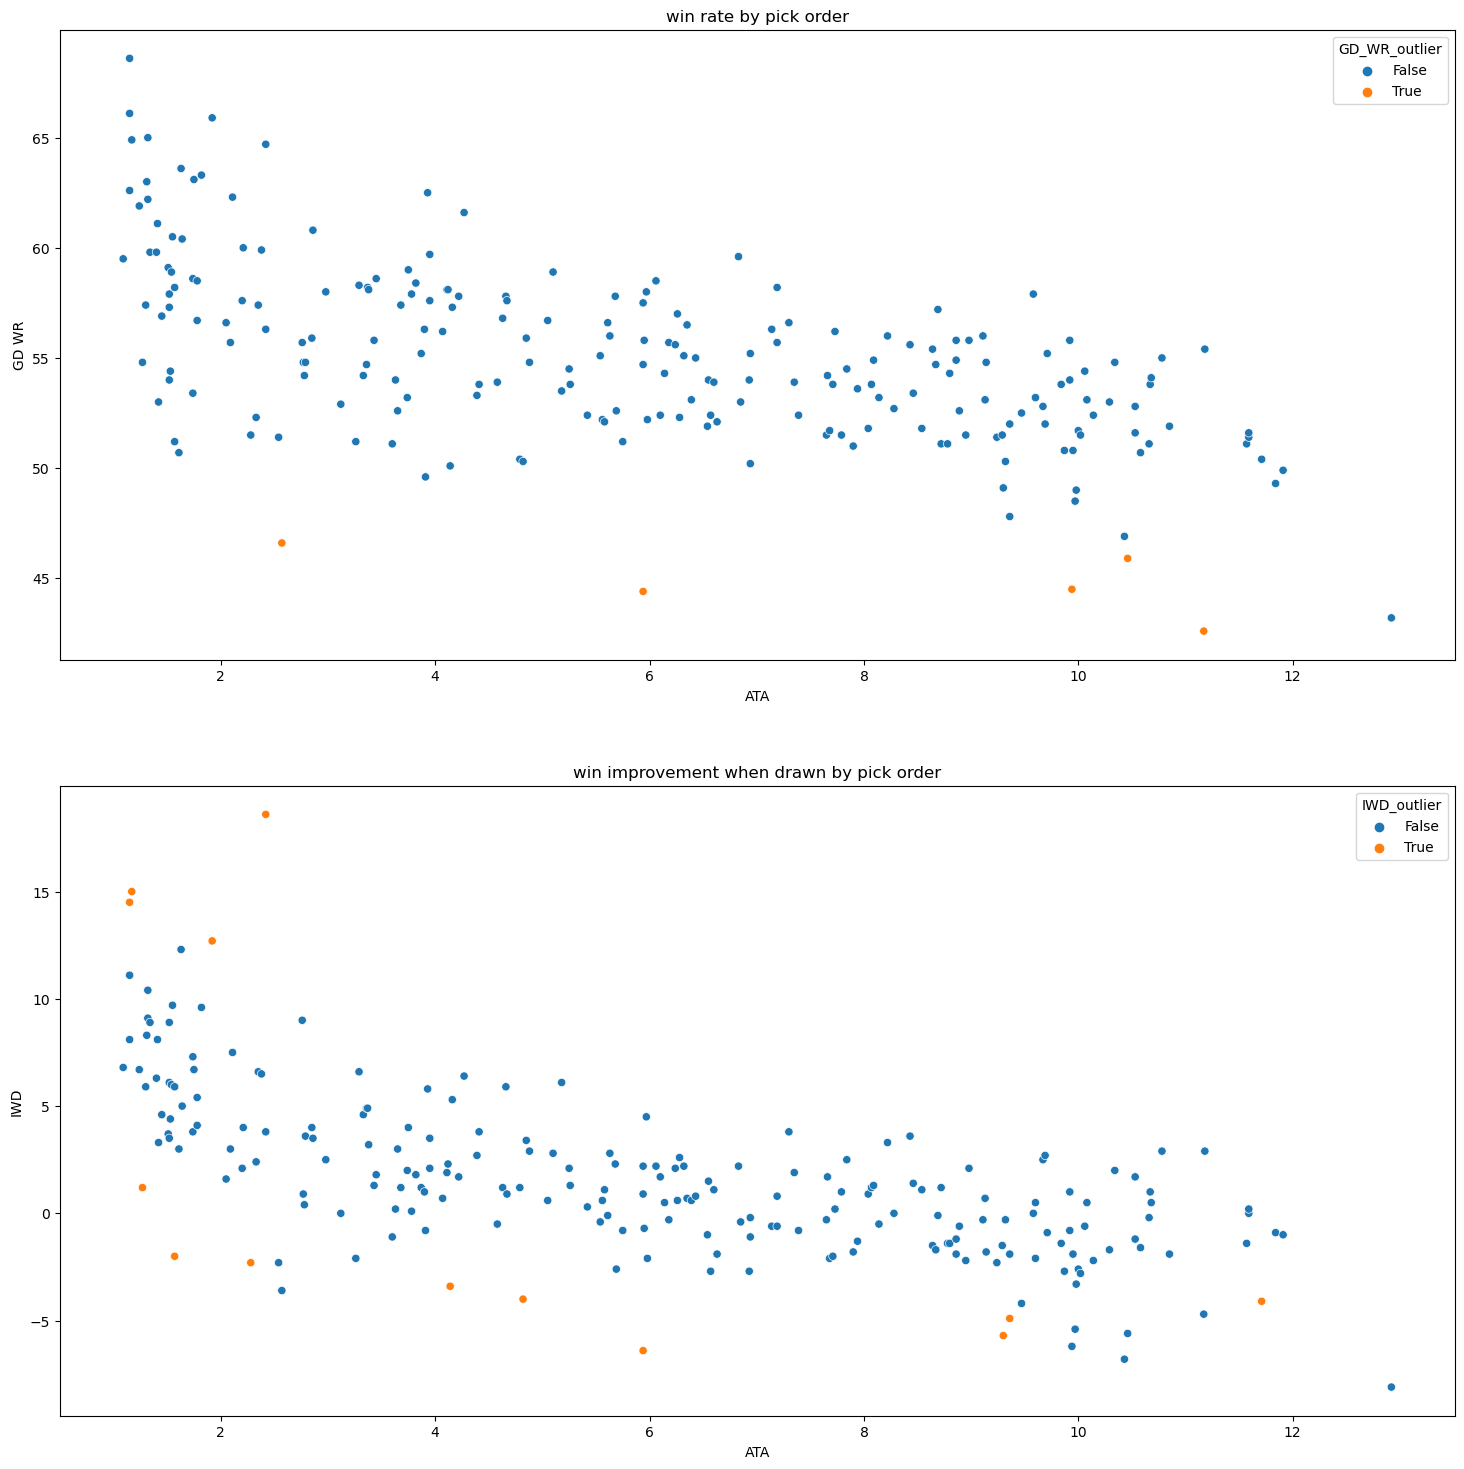

In [24]:
#plot of win rate over pick order
fig, ax = plt.subplots(nrows=2, figsize=(18,18))
sns.scatterplot(data=df, x="ATA", y="GD WR", ax=ax[0], hue="GD_WR_outlier")
ax[0].set(title="win rate by pick order", )
sns.scatterplot(data=df, x="ATA", y="IWD", ax=ax[1], hue="IWD_outlier")
ax[1].set(title="win improvement when drawn by pick order")
plt.show();

Based on this graph we can confirm the presence of outliers. However it's hard to investigate without knowing the name of the cards, let's plot this againg using plotly

In [37]:
df.columns

Index(['Name', 'Color', 'Rarity', 'ATA', 'GD WR', 'IWD', 'rounded_pick_order',
       'GD WR_q1', 'IWD_q1', 'GD WR_q3', 'IWD_q3', 'IWD_iqr', 'GD WR_iqr',
       'IWD_outlier', 'GD_WR_outlier'],
      dtype='object')

In [38]:
fig = px.scatter(df, y="GD WR", x="ATA", color="GD_WR_outlier", hover_name="Name", hover_data=["rounded_pick_order", "ATA", "GD WR_q1", "GD WR_q3"])
fig.update_traces(marker_size=10)
fig.write_html("../graph/GD_WR_outlier.html")

In [40]:
fig = px.scatter(df, y="IWD", x="ATA", color="IWD_outlier", hover_name="Name", hover_data=["rounded_pick_order", "ATA", "IWD_q1", "IWD_q3"])
fig.update_traces(marker_size=10)
fig.write_html("../graph/IWD_outlier.html")

Let's compare this graph with graphs that take the iqr for the whole dataset and not grouped by pick order

In [42]:
df[["GD_WR_all_q1", "IWD_all_q1"]] = df[["GD WR", "IWD"]].quantile(0.25)
df[["GD_WR_all_q3", "IWD_all_q3"]] = df[["GD WR", "IWD"]].quantile(0.75)


In [48]:
df.columns

Index(['Name', 'Color', 'Rarity', 'ATA', 'GD WR', 'IWD', 'rounded_pick_order',
       'GD WR_q1', 'IWD_q1', 'GD WR_q3', 'IWD_q3', 'IWD_iqr', 'GD WR_iqr',
       'IWD_outlier', 'GD_WR_outlier', 'GD_WR_all_q1', 'IWD_all_q1',
       'GD_WR_all_q3', 'IWD_all_q3', 'IWD_all_iqr'],
      dtype='object')

In [52]:
df["IWD_all_iqr"] = df["IWD_all_q3"] - df["IWD_all_q1"]
df["GD_WR_all_iqr"] = df["GD_WR_all_q3"] - df["GD_WR_all_q1"]
df["IWD_all_outlier"] = df.apply(is_outlier, args=("IWD", "IWD_all_q1","IWD_all_q3", "IWD_all_iqr",), axis=1)
df["GD_WR_all_outlier"] = df.apply(is_outlier, args=("GD WR", "GD_WR_all_q1", "GD_WR_all_q3", "GD_WR_all_iqr"), axis=1)

In [53]:
fig = px.scatter(df, y="GD WR", x="ATA", color="GD_WR_all_outlier", hover_name="Name", hover_data=["rounded_pick_order", "ATA", "GD_WR_all_q1", "GD_WR_all_q3"])
fig.update_traces(marker_size=10)
fig.write_html("../graph/GD_WR_all_outlier.html")

In [55]:
fig = px.scatter(df, y="IWD", x="ATA", color="IWD_all_outlier", hover_name="Name", hover_data=["rounded_pick_order", "ATA", "IWD_all_q1", "IWD_all_q3"])
fig.update_traces(marker_size=10)
fig.write_html("../graph/IWD_all_outlier.html")

This is not very informative, however we can see that the card "Geth, thane of contracts" is clearly overvalued.